# Space Titanic

## Imports

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Data exploration (round 1)

In [2]:
## Import data

train = pd.read_csv("Datasets/SpaceTitanic/train.csv")
test = pd.read_csv("Datasets/SpaceTitanic/test.csv")
df = pd.concat([train, test])

df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter,NaN
4273,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron,NaN
4274,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,NaN
4275,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,NaN


In [3]:
# Some other data exploration

# Null check
print(df.info())

# Columns Unique count
print(df["HomePlanet"].nunique(), df["Destination"].nunique(), train["Transported"].value_counts())

<class 'pandas.core.frame.DataFrame'>
Index: 12970 entries, 0 to 4276
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12682 non-null  object 
 2   CryoSleep     12660 non-null  object 
 3   Cabin         12671 non-null  object 
 4   Destination   12696 non-null  object 
 5   Age           12700 non-null  float64
 6   VIP           12674 non-null  object 
 7   RoomService   12707 non-null  float64
 8   FoodCourt     12681 non-null  float64
 9   ShoppingMall  12664 non-null  float64
 10  Spa           12686 non-null  float64
 11  VRDeck        12702 non-null  float64
 12  Name          12676 non-null  object 
 13  Transported   8693 non-null   object 
dtypes: float64(6), object(8)
memory usage: 1.5+ MB
None
3 3 Transported
True     4378
False    4315
Name: count, dtype: int64


Decisions made:
1. Low number of unique instances for HomePlanet/ CyroSleep --> turn them into dummies
2. In train["Transported"], #True $\approx$ #False, we can use accuracy as our objective function in later CV process.  

## Feature Engineering (Round 1)

In [4]:
# Convert categorical features to 1-hot encoding
df = pd.get_dummies(df, columns = ["HomePlanet", "Destination"], dtype = int)

# Convert boolean features to binary encoding
df["CryoSleep"] = pd.to_numeric(df["CryoSleep"], errors='coerce')
df["Transported"] = pd.to_numeric(df["Transported"], errors='coerce')
df["VIP"] = pd.to_numeric(df["VIP"], errors='coerce')

# Extract group member values
from collections import Counter
def extract_group(passID):
    return passID.split("_")[0]
df["PassengerGroup"] = df["PassengerId"].apply(lambda x: int(x.split("_")[0]))
pass_group_counter = Counter(df["PassengerGroup"])
df["GroupCount"] = df["PassengerGroup"].apply(lambda x: pass_group_counter[x])
df = df.drop("PassengerGroup", axis = 1)

# Extract Cabin (count) and Side
df[["Deck", "Side"]] = df["Cabin"].str.split("/", expand=True)[[0, 2]]
deck_counter = Counter(df["Deck"])
df["DeckCount"] = df["Deck"].apply(lambda x: deck_counter[x])
df = df.drop("Cabin", axis = 1)

# Dropping Name
df = df.drop("Name", axis = 1)

df

,PassengerId,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,GroupCount,Deck,Side,DeckCount
0,0001_01,0.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,1,1,B,P,1141
1,0002_01,0.0,24.0,0.0,109.0,9.0,25.0,549.0,44.0,1.0,1,0,0,0,0,1,1,F,S,4239
2,0003_01,0.0,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,0.0,0,1,0,0,0,1,2,A,S,354
3,0003_02,0.0,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,0.0,0,1,0,0,0,1,2,A,S,354
4,0004_01,0.0,16.0,0.0,303.0,70.0,151.0,565.0,2.0,1.0,1,0,0,0,0,1,1,F,S,4239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,1.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1,0,0,0,0,1,2,G,S,3781
4273,9269_01,0.0,42.0,0.0,0.0,847.0,17.0,10.0,144.0,NaN,1,0,0,0,0,1,1,NaN,NaN,299
4274,9271_01,1.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,0,1,1,0,0,1,D,P,720
4275,9273_01,0.0,NaN,0.0,0.0,2680.0,0.0,0.0,523.0,NaN,0,1,0,0,0,0,1,D,P,720


In [5]:
# seperate back to train/ test

train = df.iloc[:train.shape[0]]
test = df.iloc[train.shape[0]:]

In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4277 entries, 0 to 4276
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PassengerId                4277 non-null   object 
 1   CryoSleep                  4184 non-null   float64
 2   Age                        4186 non-null   float64
 3   VIP                        4184 non-null   float64
 4   RoomService                4195 non-null   float64
 5   FoodCourt                  4171 non-null   float64
 6   ShoppingMall               4179 non-null   float64
 7   Spa                        4176 non-null   float64
 8   VRDeck                     4197 non-null   float64
 9   Transported                0 non-null      float64
 10  HomePlanet_Earth           4277 non-null   int64  
 11  HomePlanet_Europa          4277 non-null   int64  
 12  HomePlanet_Mars            4277 non-null   int64  
 13  Destination_55 Cancri e    4277 non-null   int64  
 1

## Data Exploration (Round 2)

Boxplot

### GroupCount

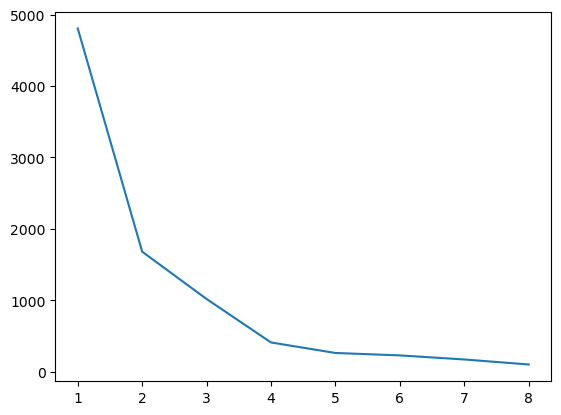

In [7]:
# Check Group Count
x = np.arange(train["GroupCount"].min(), train["GroupCount"].max()+1)

y = train["GroupCount"].value_counts()

plt.plot(x,y)

plt.show()

Majority of passengers travel alone, check relation between GroupCount and Transposted

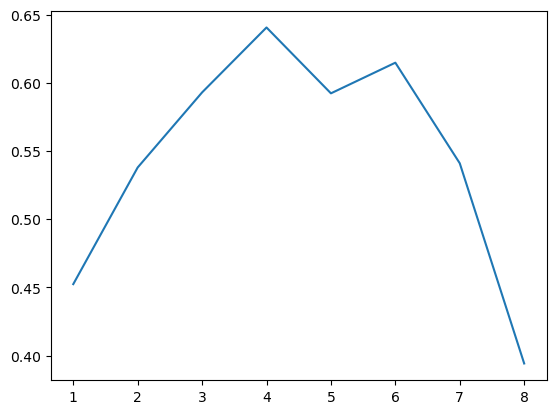

In [8]:
x = np.arange(train["GroupCount"].min(), train["GroupCount"].max()+1)

y = []

for num in x:
    survived = len(train[(train["GroupCount"] == num) & (train["Transported"] == 1)])
    total = len(train[train["GroupCount"] == num])
    y.append(survived/total)

plt.plot(x,y)

plt.show()

### Deck and Side

In [9]:
for i in train["Deck"].unique():
    print(i)
    print(train[train["Deck"] == i]["Side"].value_counts())

B
Side
S    426
P    353
Name: count, dtype: int64
F
Side
P    1438
S    1356
Name: count, dtype: int64
A
Side
S    139
P    117
Name: count, dtype: int64
G
Side
S    1283
P    1276
Name: count, dtype: int64
nan
Series([], Name: count, dtype: int64)
E
Side
S    447
P    429
Name: count, dtype: int64
D
Side
P    248
S    230
Name: count, dtype: int64
C
Side
S    406
P    341
Name: count, dtype: int64
T
Side
P    4
S    1
Name: count, dtype: int64


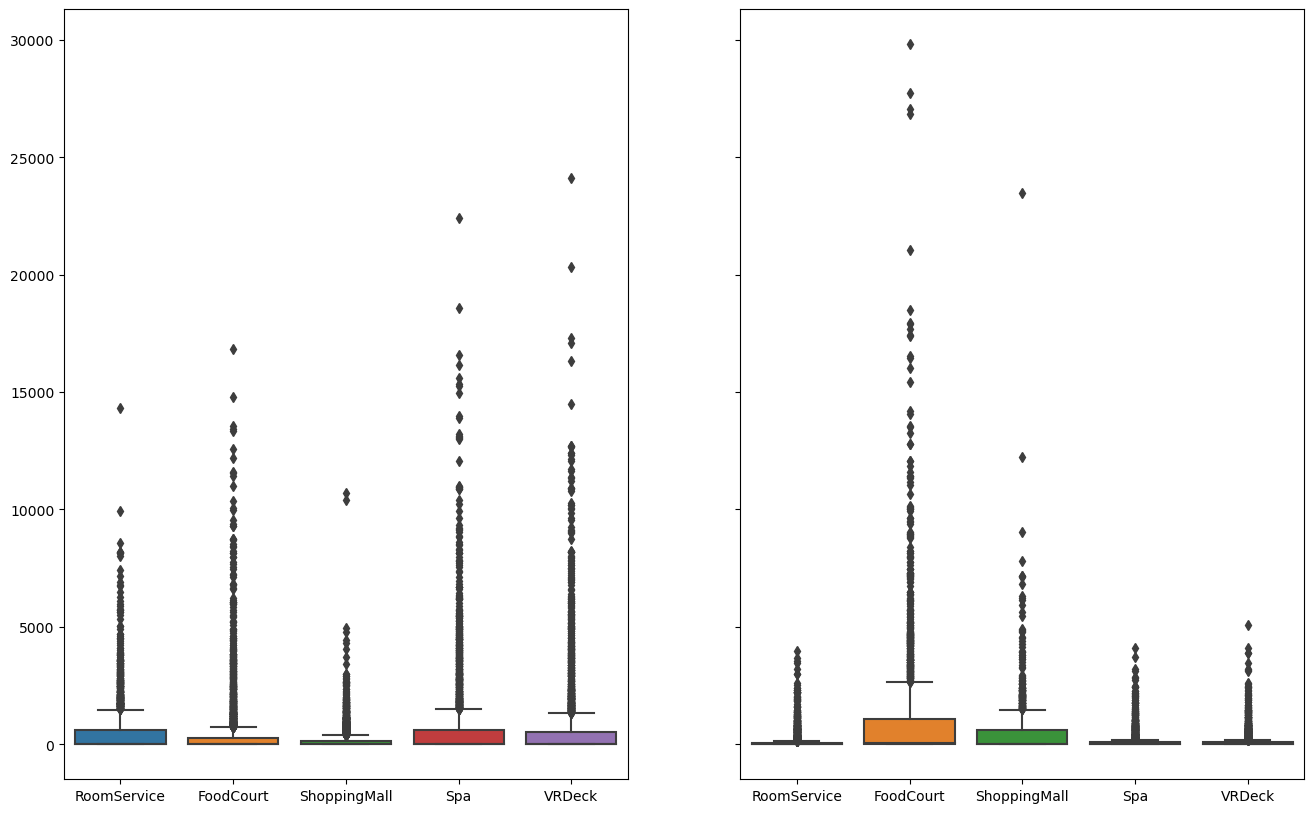

In [10]:
categories = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

fig, axs = plt.subplots(1, 2, figsize=(16, 10), sharey = True)

sns.boxplot(data = train[(train["Transported"] == 0) & (train["CryoSleep"] == 0)][categories], ax = axs[0])

sns.boxplot(data = train[(train["Transported"] == 1) & (train["CryoSleep"] == 0)][categories], ax = axs[1])

plt.show()


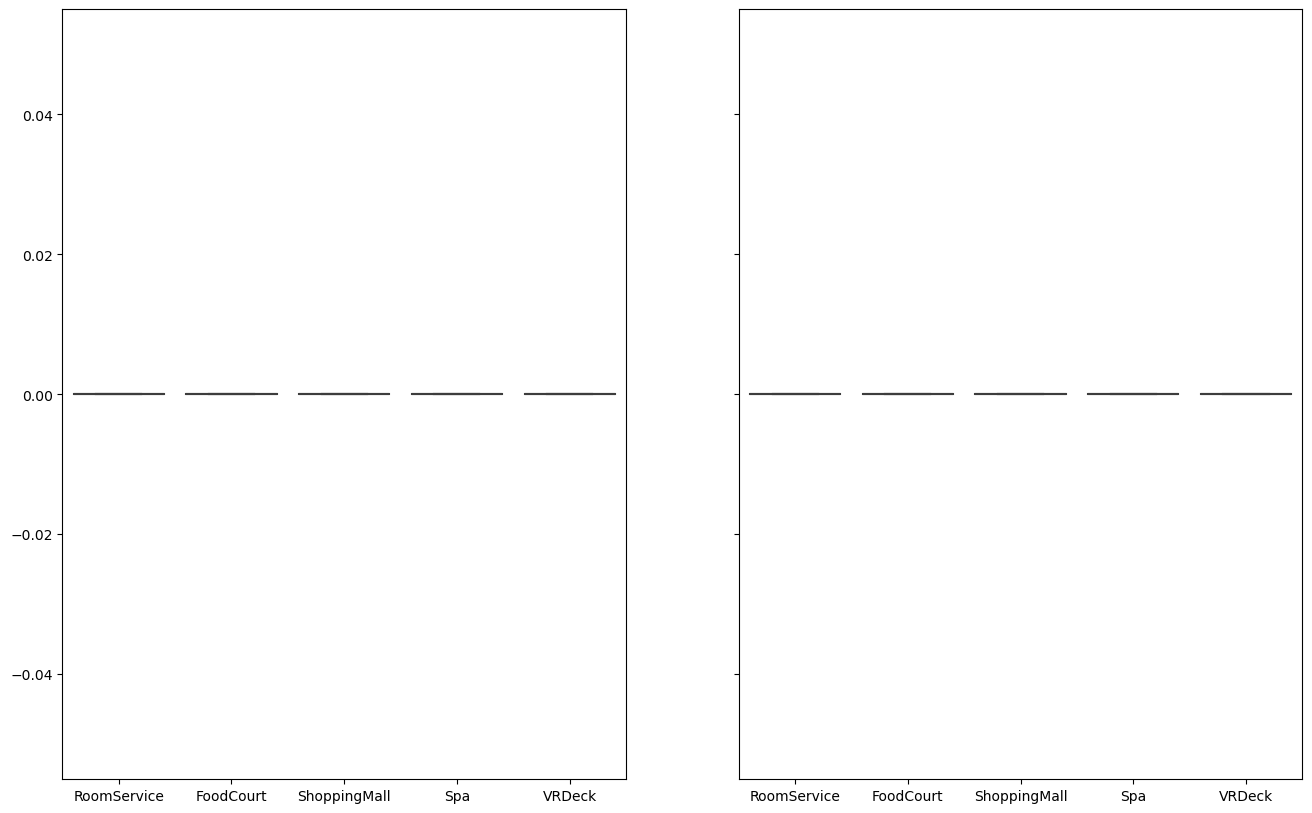

In [11]:
# Btw Cyroslept passengers do not spend any money
categories = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

fig, axs = plt.subplots(1, 2, figsize=(16, 10), sharey = True)

sns.boxplot(data = train[(train["Transported"] == 0) & (train["CryoSleep"] == 1)][categories], ax = axs[0])

sns.boxplot(data = train[(train["Transported"] == 1) & (train["CryoSleep"] == 1)][categories], ax = axs[1])

plt.show()

Decisions made:
1. GroupCount: Majority traveling alone, clear non-linearity of relation --> Change to binary variable (GroupCount = 1 and GroupCount > 1)
2. Deck/ Side: There are seats at each deck for both sides (this might not be the case, if one deck sits on only 1 side, this will result in Side being redundant, as side information would implicitly exist in the Deck feature) --> Keep it as is (convert to 1 hot encoding, obviously)
3. Spendings: Many outliers, apply log the to the features. Can clearly see that higher FoodCourt and ShoppingMall spendings correlates to transported, keep as is and let the model learn on it's own (alternatively, we can sum FoodCourt and ShoppingMall into 1 feature and the others into another feature, but this will result in lose of information and I think we have enough sample size to learn a good model anyways)
4. Spendings (cont'd): CyroSleep = 1 --> 0 spendings, to prevent contamination, standardize spending columns with CyroSleep = 0 only, no need to standardize cyrosleep = 1 because they spend nothing anyways 

## Feature Engineering (Round 2)

In [12]:
df = pd.concat([train, test])

In [13]:
# Convert GroupCount to a binary Variable
df["Alone"] = df["GroupCount"].apply(lambda x: 0 if x > 1 else 1)
df = df.drop("GroupCount", axis = 1)

# Convert Side/ Deck to 1 hot
df = pd.get_dummies(df, columns = ["Side"], dtype = int, drop_first = True)
df = pd.get_dummies(df, columns = ["Deck"], dtype = int)

# Apply Log to spending categories
categories = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
for cat in categories:
    df[cat] = df[cat].apply(lambda x: np.log1p(x))

In [14]:
# seperate back to train/ test

train = df.iloc[:train.shape[0]]
test = df.iloc[train.shape[0]:]

In [15]:
train

,PassengerId,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,...,Alone,Side_S,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T
0,0001_01,0.0,39.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,1,0,0,1,0,0,0,0,0,0
1,0002_01,0.0,24.0,0.0,4.700480,2.302585,3.258097,6.309918,3.806662,1.0,...,1,1,0,0,0,0,0,1,0,0
2,0003_01,0.0,58.0,1.0,3.784190,8.182280,0.000000,8.812248,3.912023,0.0,...,0,1,1,0,0,0,0,0,0,0
3,0003_02,0.0,33.0,0.0,0.000000,7.157735,5.918894,8.110728,5.267858,0.0,...,0,1,1,0,0,0,0,0,0,0
4,0004_01,0.0,16.0,0.0,5.717028,4.262680,5.023881,6.338594,1.098612,1.0,...,1,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,0.0,41.0,1.0,0.000000,8.827615,0.000000,7.404888,4.317488,0.0,...,1,0,1,0,0,0,0,0,0,0
8689,9278_01,1.0,18.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,1,1,0,0,0,0,0,0,1,0
8690,9279_01,0.0,26.0,0.0,0.000000,0.000000,7.535297,0.693147,0.000000,1.0,...,1,1,0,0,0,0,0,0,1,0
8691,9280_01,0.0,32.0,0.0,0.000000,6.956545,0.000000,5.869297,8.082093,0.0,...,0,1,0,0,0,0,1,0,0,0


## Standardization and KNN imputation

In [16]:
# Imports
from sklearn.impute import KNNImputer

# Features to scale
columns_to_scale = ["Age", "DeckCount"]
columns_to_scale_spendings = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

# Parameters for KNNImputer, check sklearn documentation for details
n_neighbors = 10
weights = "distance"


# Divide datasets by CyroSleep to preserve order later
train = pd.concat([train[train["CryoSleep"] != 1], train[train["CryoSleep"] == 1]])
test = pd.concat([test[test["CryoSleep"] != 1], test[test["CryoSleep"] == 1]])

# Keep relevant columns only for processing
train_features = train.drop(["Transported", "PassengerId"], axis = 1)
test_features = test.drop(["Transported", "PassengerId"], axis = 1)

# Store feature lables as standardizer/ imputer creates ndarray object (and discards the labels)
lables = train_features.columns.tolist()

# Standardization (Normal Columns)
for col in columns_to_scale:
    mean = train_features[col].mean()
    std = train_features[col].std()
    train_features[col] = (train_features[col] - mean) / std
    test_features[col] = (test_features[col] - mean) / std
    # print(f"col:{col}, std: {std}")

# Standardization (Spendings)
train_features_notcyro = train_features[train_features["CryoSleep"] != 1]
test_features_notcyro = test_features[test_features["CryoSleep"] != 1]

for col in columns_to_scale_spendings:
    mean = train_features_notcyro[col].mean()
    std = train_features_notcyro[col].std()
    train_features_notcyro[col] = (train_features_notcyro[col] - mean) / std
    test_features_notcyro[col] = (test_features_notcyro[col] - mean) / std
    
# Cyro = 1, every feature will be 0 anyways
train_features_cyro = train_features[train_features["CryoSleep"] == 1] 
test_features_cyro = test_features[test_features["CryoSleep"] == 1]

for col in columns_to_scale_spendings:
    mean = train_features_cyro[col].mean()
    std = train_features_cyro[col].std()
    train_features_cyro[col] = (train_features_cyro[col] - mean) / std
    test_features_cyro[col] = (test_features_cyro[col] - mean) / std
    
train_features = pd.concat([train_features_notcyro, train_features_cyro])
test_features = pd.concat([test_features_notcyro, test_features_cyro])

# KNN imputation
imputer = KNNImputer(n_neighbors = n_neighbors, weights = weights)
imputer.fit(train_features)
# Imputate the training set
train_imputed = imputer.transform(train_features)
train_features = pd.DataFrame(train_imputed, columns = lables)
# Impute the test set
test_imputed = imputer.transform(test_features)
test_features = pd.DataFrame(test_imputed, columns = lables)

train = pd.concat([train["Transported"], train_features], axis = 1)
test = pd.concat([test["PassengerId"], test_features], axis = 1)

/tmp/ipykernel_81371/2008387481.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_features_notcyro[col] = (train_features_notcyro[col] - mean) / std
/tmp/ipykernel_81371/2008387481.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_features_notcyro[col] = (test_features_notcyro[col] - mean) / std
/tmp/ipykernel_81371/2008387481.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

## Model Selection

Stole this section from titanic notebook

### Helper Function

In [17]:
from sklearn.model_selection import cross_validate
from tqdm import tqdm

def print_v(content, verbose): # Implement verbosity
    if verbose:
        print(content)

def cv_score_std(cv_dict):
    score_array = cv_dict["test_score"]
    return score_array.mean(), score_array.std() 

# models: list of models must satisfy the sklearn API interface
def cross_validate_many_models(models, cv_params, X, y, verbose = False, show_results = True):
    # Initialize function variables for result storage
    model_scores = []
    model_stds = []
    best_model_index = -1
    best_model_score = -1
    
    # Loop through all models
    for i, model in tqdm(enumerate(models), desc = f"Validating models"):
        
        # Performing CV
        cv_results = cross_validate(estimator = model, X = X, y = y, **cv_params)
        score, std = cv_score_std(cv_results)
        print_v(f"Model: {model}, score: {score}, std: {std}", verbose)
        
        # Storing Results
        model_scores.append(score)
        model_stds.append(std)
        
        # Updating best model
        if score > best_model_score:
            best_model_score = score
            best_model_index = i
    
    # Print Results
    if show_results:
        print("###########################################")
        print("############### Test Results ##############")
        print("###########################################")
        print("")
        print(f"Best model is {models[best_model_index]} with score: {model_scores[best_model_index]} and std: {model_stds[best_model_index]}")
    
    return best_model_index, model_scores, model_stds

### Initialize models to be tested

In [18]:
# Initializing list of models
models_list = []

# set randomness seed for reproducability
random_state = 852

# Import utils
from itertools import product

# Import models
# Linear Models
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
# Discrete Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

# Adding model to list

# Logistic Regression (With different l1, l2 penanty ratios)
ratios = np.linspace(0, 1, 101) 

for ratio in ratios:
    # Need to use SAGA solver since we use elasticnet solver
    model = LogisticRegression(penalty = "elasticnet", random_state = random_state, solver = "saga", max_iter = 1000, l1_ratio = ratio)
    models_list.append(model)
    
# Ridge Classifier
alphas = np.linspace(0, 1, 101)

for alpha in alphas:
    model = RidgeClassifier(alpha = alpha, random_state = random_state)
    models_list.append(model)
    
# C-Support Vector Classification
c_values = np.linspace(1, 10, 101)
gammas = ["scale", "auto"]
kernals = ["linear","rbf","sigmoid"]

for c, kernal, gamma in product(c_values, kernals, gammas): # Use itertools.product to avoid nested for loops (ugly)
    model = SVC(C = c, kernel = kernal, gamma = gamma)
    models_list.append(model)
    
# Naive Bayes (low/no correlation between data)
models_list.append(GaussianNB())

# KNN Classifier (bad algo, adding for demo purposes only)
for k in range(3,8):
    model = KNeighborsClassifier(n_neighbors=5, weights = "distance")
    models_list.append(model)

# Random Forest
rf_gini = RandomForestClassifier(criterion = "gini", min_samples_split = 3, random_state = random_state)
rf_log_loss = RandomForestClassifier(criterion = "log_loss", min_samples_split = 3, random_state = random_state)
models_list.append(rf_gini)
models_list.append(rf_log_loss)

# # LightGBM
# # Not using this anymore because it keeps screaming and fataling the whole test if hyperparameters are not set like this
# lgbm_gbdt = LGBMClassifier(boosting_type="gbdt",random_state = random_state, bagging_freq=5, bagging_fraction=0.8, feature_fraction=0.8, verbosity = -1)
# lgbm_rf = LGBMClassifier(boosting_type="rf",random_state = random_state, bagging_freq=5, bagging_fraction=0.8, feature_fraction=0.8, verbosity = -1)
# models_list.append(lgbm_gbdt)
# models_list.append(lgbm_rf)

# Catboost
l2_leaf_reg = list(np.linspace(0, 1, 5))
learning_rate = [0.01, 0.05, 0.1]
depth = [4, 6, 8]


for l2_leaf_reg, learning_rate, depth in product(l2_leaf_reg, learning_rate, depth):
    model = CatBoostClassifier(random_state = random_state, l2_leaf_reg = l2_leaf_reg, learning_rate=learning_rate, allow_writing_files=False, silent = True)
    models_list.append(model)


# XGboost
# Unlike LightGBM this one has no problems, pretty sure all 3 boosting libs do the same thing, so only tuning catboost
xgb_clf = XGBClassifier(objective = 'binary:logistic', max_depth = 3, random_state = random_state, verbosity = 0)
models_list.append(xgb_clf)

### Cross Validation of models

#### Preperation

In [19]:
# Preparing the training set
train = train.sample(frac = 1, random_state = 852) # Shuffle, entries grouped by "CyroSleep" during standardization
X = train.drop(["Transported"], axis = 1)
y = train["Transported"]

# Sklearn Cross Validation Parameters
cv_params = {
    "scoring": "accuracy",
    "cv": 10,
    "n_jobs": 4,
    "error_score": "raise",
    "verbose": 0
}

#### Testing

In [20]:
best_model_index, _, _ = cross_validate_many_models(models = models_list, cv_params = cv_params, X = X, y = y, verbose = False, show_results = True)

Validating models: 101it [00:49,  2.28it/s]/home/shivvorz/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=8.98168e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/shivvorz/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=6.35476e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/shivvorz/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=6.21945e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/shivvorz/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=7.53666e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite

###########################################
############### Test Results ##############
###########################################

Best model is SVC(C=3.6999999999999997, gamma='auto', kernel='sigmoid') with score: 0.5123633982778462 and std: 0.02114207860261261


## Inference

Preparing train and test set

In [21]:
X_train = train.drop(["Transported"], axis = 1)
y_train = train["Transported"]

X_test = test.drop(["PassengerId"], axis = 1)

Fitting best model and making prediction

In [22]:
clf = models_list[best_model_index]
clf.fit(X_train, y_train)
test_y = clf.predict(X_test)

Submit prediction

In [23]:
pred = pd.DataFrame()
pred["Transported"] = pd.Series(test_y)
pred["Transported"] = pred["Transported"].astype(int)
response = pd.concat([test["PassengerId"],pred], axis = 1)

response.to_csv("Datasets/SpaceTitanic/response.csv", index = False)